In [36]:
from databases import df
import kaleido
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import sklearn as skl
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,death_event_label,gender
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,True,Male
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,True,Male
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,True,Male
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,True,Male
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,True,Female


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [3]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
death_event                   int64
dtype: object

In [4]:
# Map numerical values to descriptive labels
df['death_event_label'] = df['death_event'].map({0: 'False', 1: 'True'})
df['gender'] = df['sex'].map({0: 'Female', 1: 'Male'})

In [6]:
# Create the histogram
fig = px.histogram(df, x='age', color='death_event_label', 
                   title='Age Distribution by Death Event',
                   labels={'age': 'Age', 'death_event_label': 'Death Event'},
                   color_discrete_map={'False': 'lightgreen', 'True': 'orangered'}
                  )


# Export the figure as an image
fig.write_image("Visualizations/age_distribution_histogram.png", engine="kaleido")
# Show the plot
fig.show()


In [7]:
# Create the box plot
fig = px.box(df, x='death_event_label', y='ejection_fraction', 
             title='Ejection Fraction by Death Event',
             labels={'death_event_label': 'Death Event', 'ejection_fraction': 'Ejection Fraction'})
# Export the figure as an image
fig.write_image("Visualizations/ejectionfraction_boxplot.png", engine="kaleido")
fig.show()

In [8]:
"""Create correlation heatmap of numerical features"""
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                          'platelets', 'serum_creatinine', 'serum_sodium', 'time']
correlation_matrix = df[numerical_features].corr()
    
fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='RdBu_r',
        zmin=-1, zmax=1
    ))
fig.update_layout(title='Correlation Heatmap of Numerical Features')
# Export the figure as an image
fig.write_image("Visualizations/correlation_matrix.png", engine="kaleido")
fig.show()

In [9]:
from plotly.subplots import make_subplots



# For other binary features (like 'anaemia', 'diabetes', etc.), map 0/1 to 'No'/'Yes'
binary_feature_labels = {
    'anaemia': {0: 'No', 1: 'Yes'},
    'diabetes': {0: 'No', 1: 'Yes'},
    'high_blood_pressure': {0: 'No', 1: 'Yes'},
    'smoking': {0: 'No', 1: 'Yes'},
    'sex': {0: 'Female', 1: 'Male'}
}

binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'sex']

# Create a subplot layout
fig = make_subplots(rows=2, cols=3, 
                    subplot_titles=[feature.replace("_", " ").title() for feature in binary_features],
                    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}],
                           [{'type': 'domain'}, {'type': 'domain'}, None]])

# Add pie charts for each binary feature
for i, feature in enumerate(binary_features):
    row = i // 3 + 1
    col = i % 3 + 1
    if feature == 'sex':  # For the 'sex' feature, use gender labels
        values = df['gender'].value_counts()
        labels = ['Female', 'Male']
        colors = ['purple', 'orange']  # Set custom colors for Female and Male
    else:  # For other binary features, map 0/1 to 'No'/'Yes'
        values = df[feature].map(binary_feature_labels[feature]).value_counts()
        labels = list(binary_feature_labels[feature].values())  # Convert dict_values to a list
        colors = ['purple', 'orange']  # Use the same color scheme for all binary features

    fig.add_trace(
        go.Pie(labels=labels, values=values.values, name=feature, 
               marker=dict(colors=colors)),  # Apply colors to the pie chart slices
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title_text="Distributions of Binary Features",
    height=700, width=900,
    showlegend=False  # Show the legend
)
# Export the figure as an image
fig.write_image("Visualizations/binary_features_pie.png", engine="kaleido")
# Show the plot
fig.show()

In [10]:
# Group data by 'sex' and 'death_event'
death_by_sex = df.groupby(['gender', 'death_event']).size().reset_index(name='count')

# Ensure 'death_event' is treated as a categorical variable
death_by_sex['death_event'] = death_by_sex['death_event'].astype('category')

# Create the bar chart
fig = px.bar(death_by_sex, x='gender', y='count', 
             title='Death Event by Gender',
             labels={'gender': 'Gender', 'count': 'Count', 'death_event': 'Death Event'},
             color='death_event',  # Use 'death_event' for coloring
             color_discrete_map={0: 'green', 1: 'red'})  # Force specific colors for 'death_event'

# Update layout to remove the legend, add x-axis labels, and set axis labels
fig.update_layout(
    showlegend=False,  # Hide legend
    xaxis_title='Gender',  # Set the x-axis title
    yaxis_title='Count',  # Set the y-axis title
    xaxis={'tickmode': 'array', 'tickvals': ['Female', 'Male'], 'ticktext': ['Female', 'Male']}  # Set x-axis labels
)
# Export the figure as an image
fig.write_image("Visualizations/death_by_gender.png", engine="kaleido")
# Show the plot
fig.show()


Logistic Regression Model

In [12]:
# Scale numerical features

scaler = StandardScaler()
features = df.drop(columns=['death_event_label','gender'])
scaled_features = scaler.fit_transform(features)
# Convert scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
# Add the 'death_event' column back
df_scaled['death_event'] = df['death_event'].values

In [13]:
# Logistic Regression Prep
X = df_scaled.drop(columns=['death_event'])
y = df_scaled['death_event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Train Logistic Regression Model

logistic_model = LogisticRegression(max_iter=1000, C=1.0)  
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [15]:
# Logistic Regression Evaluation

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Logistic Regression Performance:
Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.93      0.56      0.70        25

    accuracy                           0.80        60
   macro avg       0.84      0.77      0.77        60
weighted avg       0.83      0.80      0.79        60



In [16]:
# Confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[34  1]
 [11 14]]


In [17]:
#Improve performance evaluation using cross-validation.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean CV Accuracy:", scores.mean())

Cross-validation scores: [0.85416667 0.875      0.91666667 0.77083333 0.74468085]
Mean CV Accuracy: 0.8322695035460992


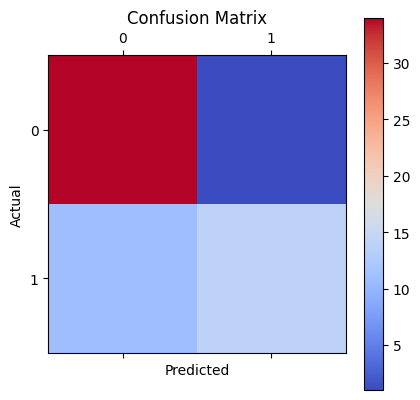

In [18]:
# Visualization: Confusion Matrix

plt.matshow(conf_matrix, cmap="coolwarm")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('Visualizations/logistic_confusion_matrix.png')
plt.show()

In [19]:
# Linear Regression for Survival Time

X_linear = df.drop(columns=['time', 'death_event','death_event_label','gender'])
y_linear = df['time']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

In [20]:
linear_model = LinearRegression()
linear_model.fit(X_train_lin, y_train_lin)
y_pred_lin = linear_model.predict(X_test_lin)

In [21]:
# Linear Regression Evaluation

mse = mean_squared_error(y_test_lin, y_pred_lin)
r2 = r2_score(y_test_lin, y_pred_lin)
print("\nLinear Regression Performance:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Linear Regression Performance:
Mean Squared Error: 5597.990189578112
R-squared: -0.020427300502624757


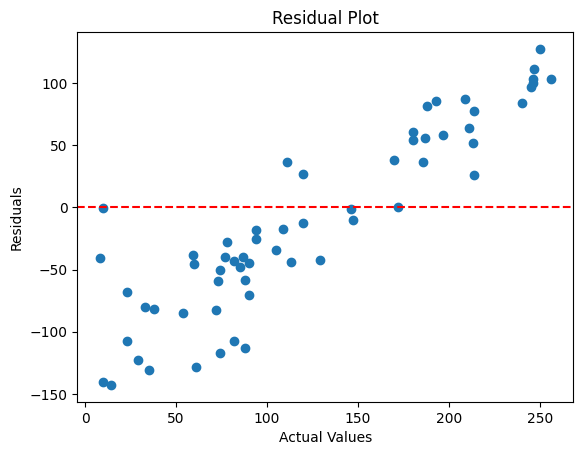

In [22]:
# Visualization: Residual Plot

residuals = y_test_lin - y_pred_lin
plt.scatter(y_test_lin, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.savefig('Visualizations/linear_residual_plot.png')
plt.show()

In [28]:
#Optimize model performance by tuning hyperparameters.
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1}


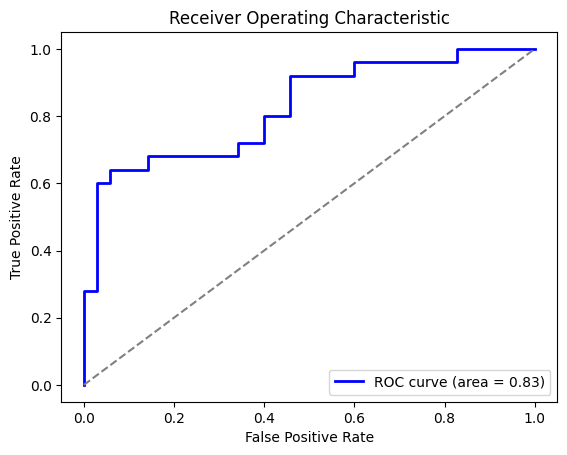

In [24]:
#generates an ROC (Receiver Operating Characteristic) curve and 
# calculates the AUC (Area Under the Curve) to evaluate the performance of my
#  logistic regression model.
from sklearn.metrics import roc_curve, auc

y_prob = logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('Visualizations/linear_roc.png')
plt.show()



    Understanding the Graph: X-axis (False Positive Rate - FPR): This represents the proportion of negatives (0s) that were incorrectly classified as positives (1s). In your case, these are the individuals who survived (DEATH_EVENT = 0) but were incorrectly predicted as having the event (death). The lower this value, the fewer false positives your model is generating. Y-axis (True Positive Rate - TPR): This represents the proportion of positives (1s) that were correctly classified as positives (1s). In your case, these are the individuals who actually had a death event (DEATH_EVENT = 1) and were correctly predicted as having the event. The higher this value, the better your model is at identifying the death event accurately. The blue ROC curve: Shows how well your model performs at various thresholds for classifying an individual as having a death event. The curve plots the trade-off between TPR and FPR for different threshold values (from 0 to 1). The diagonal grey line: Represents the performance of a random classifier. A random model, which doesn’t use any real predictive power, will have an ROC curve that follows this line. Any curve that lies above the grey line indicates better-than-random performance.
    What Does the AUC Tell You? The AUC (Area Under the Curve) quantifies the overall performance of the model by calculating the area under the ROC curve.

AUC = 1: A perfect model with no false positives or false negatives. AUC = 0.5: The model performs no better than random guessing (random classifier). AUC between 0.5 and 1: The model has some ability to distinguish between the two classes (death vs survival). A higher AUC means the model is better at making correct predictions. In your case, you can see from the label label='ROC curve (area = %0.2f)' % roc_auc on the graph what the exact AUC value is.

If AUC > 0.7, it indicates that your model is likely performing well in distinguishing between survivors and those who had the death event. If AUC is around 0.5, the model might not have much discriminative ability, and its performance is similar to random guessing. 3. Interpreting Your Model’s ROC Curve: Curve above the diagonal: If your ROC curve is well above the diagonal grey line, this indicates that your logistic regression model has some predictive power. The further the curve is from the diagonal, the better the model is at distinguishing between positive and negative cases. Curvature: The steeper the initial curve (closer to the top-left corner), the better your model is at classifying the positives with a low false positive rate. Area under the curve (AUC): If your AUC is close to 1, this is a good indicator that the model is effectively predicting the death events. If it's closer to 0.5, it suggests that the model is either performing poorly or just randomly predicting the outcomes. 4. What Else Can You Do? Threshold Tuning: The ROC curve allows you to evaluate your model’s performance at different thresholds for classification. By adjusting the threshold, you can either reduce false positives or false negatives, depending on your goal. For instance, if minimizing false negatives (predicting death events when they didn’t happen) is more important, you could adjust the threshold accordingly.

Compare Multiple Models: You could compare the ROC curves and AUC scores of different classification models (e.g., Logistic Regression, Decision Trees, SVMs, etc.) to see which one performs better in your case.


In [25]:
# Feature correlation analysis

correlations = df.drop(columns=['death_event_label','gender']).corr()
time_correlation = correlations["time"].sort_values(ascending=False)
print("\nCorrelation with Survival Time:\n", time_correlation)


Correlation with Survival Time:
 time                        1.000000
serum_sodium                0.087640
ejection_fraction           0.041729
diabetes                    0.033726
platelets                   0.010514
creatinine_phosphokinase   -0.009346
sex                        -0.015608
smoking                    -0.022839
anaemia                    -0.141414
serum_creatinine           -0.149315
high_blood_pressure        -0.196439
age                        -0.224068
death_event                -0.526964
Name: time, dtype: float64


In [26]:
# Feature correlation analysis

time_correlation = correlations["death_event"].sort_values(ascending=False)
print("\nCorrelation with Death Event:\n", time_correlation)


Correlation with Death Event:
 death_event                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: death_event, dtype: float64


c:\Users\Shari\Desktop\Data Science Course\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



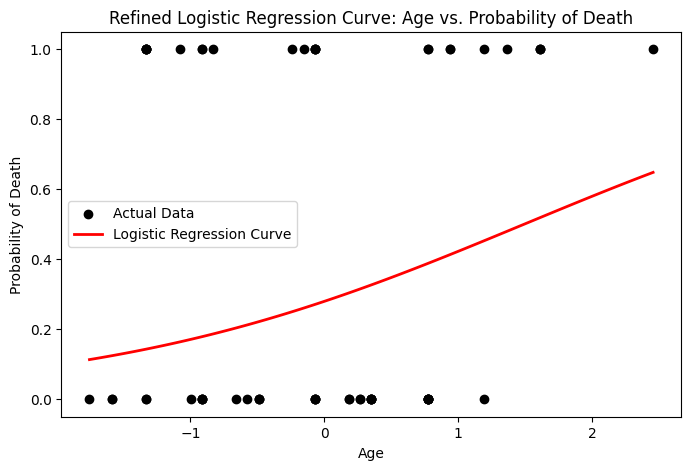

In [28]:
# Train a logistic regression model using only 'age'
X_age = X_train[['age']]  # Training set with only 'age'
X_age_test = X_test[['age']]  # Test set with only 'age'
model_age = LogisticRegression(max_iter=1000)
model_age.fit(X_age, y_train)

# Generate probabilities for a range of 'age'
age_range = np.linspace(X_age_test['age'].min(), X_age_test['age'].max(), 100).reshape(-1, 1)
probabilities_age = model_age.predict_proba(age_range)[:, 1]

# Plot the refined logistic regression curve
plt.figure(figsize=(8, 5))
plt.scatter(X_age_test, y_test, color='black', label='Actual Data')
plt.plot(age_range, probabilities_age, color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Age')
plt.ylabel('Probability of Death')
plt.title('Refined Logistic Regression Curve: Age vs. Probability of Death')
plt.legend()
plt.savefig('Visualizations/logistic_regression_curve.png')
plt.show()

Gradient Boosting

In [37]:
# Separating features "X" from target variable "y"
y = df ['death_event'] # target/dependent variables
X = df.drop(columns=['death_event','death_event_label','gender']) # features/independent variables
# Separating data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [38]:
# Scaling Dataset

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [39]:
# Using XGBoot as the gradient boosting classifier model

#training the model

clf = XGBClassifier(max_depth=5)
clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
# Predict on the test set
y_pred_xgboost = clf.predict(X_test_scaled)

In [41]:
target_labels = ["Death Report","No Death Report"]
print(classification_report(y_test, y_pred_xgboost, target_names=target_labels))

                 precision    recall  f1-score   support

   Death Report       0.94      0.93      0.94        55
No Death Report       0.81      0.85      0.83        20

       accuracy                           0.91        75
      macro avg       0.88      0.89      0.88        75
   weighted avg       0.91      0.91      0.91        75



ImportError: You must install graphviz to plot tree

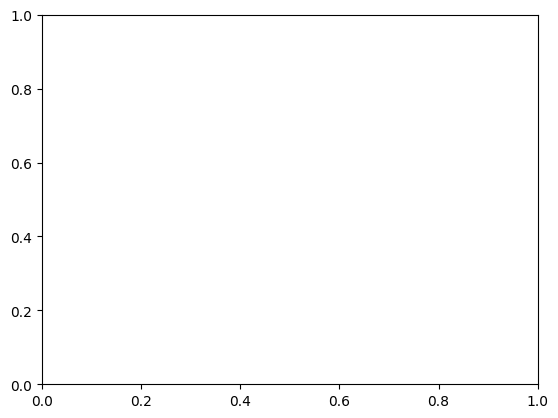

In [43]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(clf)

# Visualizing a single decision tree (the first)
plt.show()

Neural Network

In [29]:
# Split data into features and target arrays

y = df['death_event'].values
X = df.drop(['death_event','death_event_label','gender'], axis='columns').values

# Split data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [31]:
# Create a  StandardScaler Instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
# Define input features
input_feat = X_train.shape[1]

# Create model with recommended input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_feat,)),
    tf.keras.layers.Dense(50, 
        activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(100, 
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Fit model
history = model.fit(
    X_train_scaled, y_train, 
    validation_split=0.2,
    epochs=50, 
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6010 - loss: 0.7760 - val_accuracy: 0.6667 - val_loss: 0.7393
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6953 - loss: 0.7020 - val_accuracy: 0.6667 - val_loss: 0.7211
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.6569 - val_accuracy: 0.6667 - val_loss: 0.7054
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7273 - loss: 0.6489 - val_accuracy: 0.6889 - val_loss: 0.6897
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7117 - loss: 0.6375 - val_accuracy: 0.7111 - val_loss: 0.6732
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7298 - loss: 0.6302 - val_accuracy: 0.6889 - val_loss: 0.6575
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8394 - loss: 0.5433 - val_accuracy: 0.7111 - val_loss: 0.6457
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7545 - loss: 0.5582 - val_accuracy: 0.6889 - val_loss: 0.6317
Epoch 9

In [33]:
# Evaluate model using test data

model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 6ms/step - accuracy: 0.8400 - loss: 0.4502
Loss: 0.4502114951610565, Accurac: 0.8399999737739563


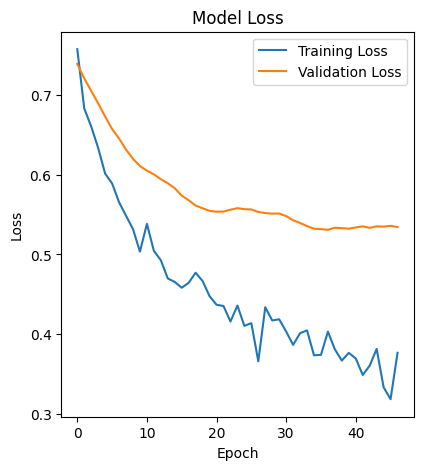

In [34]:
# Assuming 'history' is from your model.fit()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Visualizations/model_loss.png')
plt.show()

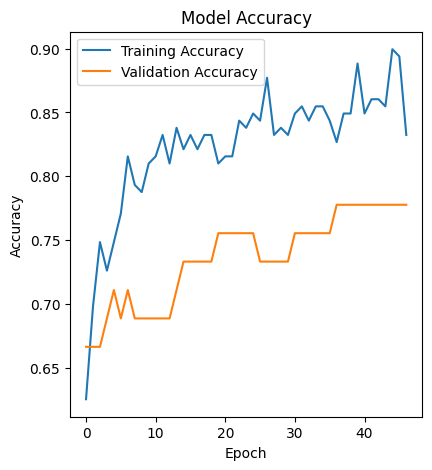

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Visualizations/model_accuracy.png')
plt.show()